# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.manual_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Our implementation of Compact Transformer Model

In [2]:
# MultiHeadAttention Module
class MSA(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=3, dropout: float=0):
        super().__init__()
        # layer normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # multiheadattention layer
        self.msa_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=dropout,
                                                   batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        # query, key, value are formed from the same x
        x, _ = self.msa_attention(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
        return x
    
# MLP layer   
class MLP(nn.Module):
    def __init__(self, 
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 dropout: float=0.1):
        super().__init__()
        # layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # two linear layers separated by GeLU activation
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size), # from input_dim to mlp_size
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size, # from mlp_size to input_dim
                        out_features=embedding_dim),
                nn.Dropout(p=dropout))
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x
        
# Transformer encoder block
class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=192,
                 num_heads: int=3,
                 mlp_size: int=768,
                 mlp_dropout: float=0.1,
                 msa_dropout: float=0.0):
        super().__init__()
        # each block (layer) consists of MSA and MLP
        self.msa = MSA(embedding_dim=embedding_dim,
                       num_heads=num_heads,
                       dropout=msa_dropout)
        
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa(x) + x # skip connection #1
        x = self.mlp(x) + x # skip connection #2
        
        return x


# taken from CVT-CCT paper
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size: int=7, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding: int=1,
                 conv_layers: int=2, input_channels: int=3, 
                 output_channels: int=64, in_planes: int=64):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, in_planes, 
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.max_pool = nn.MaxPool2d(kernel_size=pooling_kernel_size,
                                     stride=pooling_stride,
                                     padding=pooling_padding)
        
        self.conv2 = nn.Conv2d(in_planes, in_planes+in_planes,       # TODO change
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.conv3 = nn.Conv2d(in_planes+in_planes, output_channels,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)


class CvT(nn.Module):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__()
        
        self.tokenizer = Tokenizer(kernel_size=kernel_size, stride=stride, 
                                   padding=padding, pooling_kernel_size=pooling_kernel_size, 
                                   pooling_stride=pooling_stride, pooling_padding=pooling_padding, 
                                   conv_layers=conv_layers, input_channels=in_channels, 
                                   output_channels=embedding_dim, in_planes=in_planes)
        
        self.attention_pool = nn.Linear(embedding_dim, 1)
        
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        
        self.encoder = nn.Sequential(*[
            EncoderBlock(embedding_dim=embedding_dim,
                         num_heads=num_heads,
                         mlp_size=mlp_size,
                         mlp_dropout=mlp_dropout,
                         msa_dropout=msa_dropout)
            for _ in range(layers)
        ])
        
        self.norm = nn.LayerNorm(embedding_dim)
        
        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.tokenizer(x)
        x = self.emb_dropout(x)
        x = self.encoder(x)
        x = self.norm(x)
        x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        x = self.head(x)
        
        return x
    
class CvT_3(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=3, embedding_dim: int=192, mlp_size: int=384,
                 num_heads: int=3, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_7(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_14(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=14, embedding_dim: int=384, mlp_size: int=1152,
                 num_heads: int=6, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)

# Setting up config Parameters

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 7,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [12]:
model = CvT_14()
model = model.to(config['DEVICE'])
model_name = "cvt_14"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CvT_14 (CvT_14)                                         [32, 3, 224, 224]    [32, 10]             --                   True
├─Tokenizer (tokenizer)                                 [32, 3, 224, 224]    [32, 49, 384]        --                   True
│    └─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─MaxPool2d (max_pool)                             [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Conv2d (conv2)                                   [32, 64, 56, 56]     [32, 128, 28, 28]    401,408              True
│    └─MaxPool2d (max_pool)                             [32, 128, 28, 28]    [32, 128, 14, 14]    --                   --
│    └─Conv2d (conv3)                                   [32, 128, 14, 14]    [32, 384, 7, 7]      2,408,448            True
│    └─

# Training

Training: 100%|██████████| 281/281 [01:19<00:00,  3.54it/s]


Epoch 1 | Train Loss: 2.3159537977171114 | Accuracy: 0.11923741568649311 | Precision: 0.1135965661448037 | Recall: 0.11923741568649311 | F1: 0.11080424458319041


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.2480415827791456 | Accuracy: 0.15451505016722408 | Precision: 0.08312372602678217 | Recall: 0.15451505016722408 | F1: 0.08869938047425995
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 2 | Train Loss: 1.808553952339281 | Accuracy: 0.3374770054072133 | Precision: 0.3219228930475476 | Recall: 0.3374770054072133 | F1: 0.32448453873029304


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.41it/s]


	Validation Loss: 1.3430250757177111 | Accuracy: 0.5036789297658862 | Precision: 0.5354881104586546 | Recall: 0.5036789297658862 | F1: 0.46377159333865636
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [01:24<00:00,  3.33it/s]


Epoch 3 | Train Loss: 1.088664876608662 | Accuracy: 0.6161435977479235 | Precision: 0.6060366899667156 | Recall: 0.6161435977479235 | F1: 0.6078728515673419


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.40it/s]


	Validation Loss: 0.6913294985260762 | Accuracy: 0.758082497212932 | Precision: 0.771933480256777 | Recall: 0.758082497212932 | F1: 0.7439877094674677
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.36it/s]


Epoch 4 | Train Loss: 0.602708915109312 | Accuracy: 0.80110374045376 | Precision: 0.7978803700968979 | Recall: 0.80110374045376 | F1: 0.7982950436920259


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.39it/s]


	Validation Loss: 0.3985668548815687 | Accuracy: 0.8713489409141583 | Precision: 0.8761579180275497 | Recall: 0.8713489409141583 | F1: 0.8647567944626109
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 5 | Train Loss: 0.3659071570189398 | Accuracy: 0.8821004515301857 | Precision: 0.8809437484488749 | Recall: 0.8821004515301857 | F1: 0.8811978301957407


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.35it/s]


	Validation Loss: 0.29378426295350973 | Accuracy: 0.907469342251951 | Precision: 0.9125632464726477 | Recall: 0.907469342251951 | F1: 0.9045858968087633
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.43it/s]


Epoch 6 | Train Loss: 0.25510186641029614 | Accuracy: 0.9187245665867663 | Precision: 0.9183346667764012 | Recall: 0.9187245665867663 | F1: 0.9183632074663396


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.31it/s]


	Validation Loss: 0.18065069888679075 | Accuracy: 0.9422519509476032 | Precision: 0.9447749386839933 | Recall: 0.9422519509476032 | F1: 0.9416418081749951
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 7 | Train Loss: 0.1885743647203963 | Accuracy: 0.9398517197168181 | Precision: 0.939664784082517 | Recall: 0.9398517197168181 | F1: 0.9397167463891721


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.29it/s]


	Validation Loss: 0.16029876911304367 | Accuracy: 0.9505016722408027 | Precision: 0.9530244746665328 | Recall: 0.9505016722408027 | F1: 0.9508193101375736
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.41it/s]


Epoch 8 | Train Loss: 0.15106605172316376 | Accuracy: 0.9516138023301187 | Precision: 0.9514932778504543 | Recall: 0.9516138023301187 | F1: 0.951519425755401


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.22it/s]


	Validation Loss: 0.10302011959884368 | Accuracy: 0.9698996655518395 | Precision: 0.9700944371518535 | Recall: 0.9698996655518395 | F1: 0.9698812856196332
Saving best model at epoch 8...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.46it/s]


Epoch 9 | Train Loss: 0.12480540654466246 | Accuracy: 0.9628741847371648 | Precision: 0.9628619919882547 | Recall: 0.9628741847371648 | F1: 0.9628372689543393


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.27it/s]


	Validation Loss: 0.12244056949628071 | Accuracy: 0.9620958751393534 | Precision: 0.9634536614441985 | Recall: 0.9620958751393534 | F1: 0.9615213758853497


Training: 100%|██████████| 281/281 [01:23<00:00,  3.37it/s]


Epoch 10 | Train Loss: 0.12086999918138641 | Accuracy: 0.9617592953899325 | Precision: 0.9617059799217431 | Recall: 0.9617592953899325 | F1: 0.9617119979865014


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.16it/s]


	Validation Loss: 0.10871131983126553 | Accuracy: 0.9654403567447045 | Precision: 0.967848764333546 | Recall: 0.9654403567447045 | F1: 0.9658983979950536


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 11 | Train Loss: 0.09844748289705489 | Accuracy: 0.9694520318858353 | Precision: 0.9694171311083308 | Recall: 0.9694520318858353 | F1: 0.9694188055301817


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.29it/s]


	Validation Loss: 0.08339888885499201 | Accuracy: 0.974581939799331 | Precision: 0.9749935674434537 | Recall: 0.974581939799331 | F1: 0.9744612566911957
Saving best model at epoch 11...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 12 | Train Loss: 0.08715467795636836 | Accuracy: 0.9725179775907241 | Precision: 0.9725251233604965 | Recall: 0.9725179775907241 | F1: 0.9725109675537904


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.34it/s]


	Validation Loss: 0.062326774712730675 | Accuracy: 0.9814938684503902 | Precision: 0.9819987347501685 | Recall: 0.9814938684503902 | F1: 0.9815152746228314
Saving best model at epoch 12...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.46it/s]


Epoch 13 | Train Loss: 0.09007653870430918 | Accuracy: 0.9719047884497464 | Precision: 0.9718771123186305 | Recall: 0.9719047884497464 | F1: 0.971885645411527


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.45it/s]


	Validation Loss: 0.06897281023713064 | Accuracy: 0.9779264214046822 | Precision: 0.9783290551154052 | Recall: 0.9779264214046822 | F1: 0.9779495576972026


Training: 100%|██████████| 281/281 [01:19<00:00,  3.53it/s]


Epoch 14 | Train Loss: 0.07304921220272143 | Accuracy: 0.9773677462511846 | Precision: 0.9773567361749131 | Recall: 0.9773677462511846 | F1: 0.9773527527216321


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.40it/s]


	Validation Loss: 0.06377407547716103 | Accuracy: 0.9819397993311036 | Precision: 0.9820924703239289 | Recall: 0.9819397993311036 | F1: 0.9819396544060641


Training: 100%|██████████| 281/281 [01:20<00:00,  3.48it/s]


Epoch 15 | Train Loss: 0.07808803326161944 | Accuracy: 0.9755281788282513 | Precision: 0.9755336156456339 | Recall: 0.9755281788282513 | F1: 0.9755203189097318


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.47it/s]


	Validation Loss: 0.09010298469458038 | Accuracy: 0.9698996655518395 | Precision: 0.9719861252601092 | Recall: 0.9698996655518395 | F1: 0.9701435621887577


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 16 | Train Loss: 0.059594133420552385 | Accuracy: 0.9816043257706673 | Precision: 0.9815949106988995 | Recall: 0.9816043257706673 | F1: 0.9815934169314434


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


	Validation Loss: 0.05919894507863152 | Accuracy: 0.9803790412486064 | Precision: 0.9805451280171724 | Recall: 0.9803790412486064 | F1: 0.9803863939183245
Saving best model at epoch 16...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 17 | Train Loss: 0.06062288624831074 | Accuracy: 0.9803779474887118 | Precision: 0.98038942622105 | Recall: 0.9803779474887118 | F1: 0.9803741468545916


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.26it/s]


	Validation Loss: 0.05448805568346255 | Accuracy: 0.9859531772575251 | Precision: 0.986165056470998 | Recall: 0.9859531772575251 | F1: 0.9859570580982119
Saving best model at epoch 17...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.53it/s]


Epoch 18 | Train Loss: 0.056050771099989204 | Accuracy: 0.9822732593790067 | Precision: 0.982275237065414 | Recall: 0.9822732593790067 | F1: 0.9822694145775246


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.30it/s]


	Validation Loss: 0.06265206771253437 | Accuracy: 0.9823857302118172 | Precision: 0.9825524164478636 | Recall: 0.9823857302118172 | F1: 0.982353725436602


Training: 100%|██████████| 281/281 [01:18<00:00,  3.60it/s]


Epoch 19 | Train Loss: 0.056401610732396724 | Accuracy: 0.9833324042588774 | Precision: 0.9833303493926759 | Recall: 0.9833324042588774 | F1: 0.9833288136601782


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


	Validation Loss: 0.05758964006369278 | Accuracy: 0.9817168338907469 | Precision: 0.9821310292994986 | Recall: 0.9817168338907469 | F1: 0.9817210330883217


Training: 100%|██████████| 281/281 [01:20<00:00,  3.51it/s]


Epoch 20 | Train Loss: 0.04769243199785913 | Accuracy: 0.9852277161491722 | Precision: 0.9852295243176661 | Recall: 0.9852277161491722 | F1: 0.985226706372691


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.44it/s]


	Validation Loss: 0.06300393705630124 | Accuracy: 0.9803790412486064 | Precision: 0.9810227401255911 | Recall: 0.9803790412486064 | F1: 0.980424091801605


Training: 100%|██████████| 281/281 [01:17<00:00,  3.62it/s]


Epoch 21 | Train Loss: 0.04695007594027208 | Accuracy: 0.9846702714755561 | Precision: 0.9846591018004252 | Recall: 0.9846702714755561 | F1: 0.9846626730996684


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


	Validation Loss: 0.04574129125431285 | Accuracy: 0.9855072463768116 | Precision: 0.9856693425384545 | Recall: 0.9855072463768116 | F1: 0.9855087515905939
Saving best model at epoch 21...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.44it/s]


Epoch 22 | Train Loss: 0.04158431025564976 | Accuracy: 0.987123028039467 | Precision: 0.9871351827440819 | Recall: 0.987123028039467 | F1: 0.9871254359580532


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.43it/s]


	Validation Loss: 0.04942000799313922 | Accuracy: 0.9859531772575251 | Precision: 0.9860628736356905 | Recall: 0.9859531772575251 | F1: 0.9859446730654233


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 23 | Train Loss: 0.0405588729060139 | Accuracy: 0.9876804727130832 | Precision: 0.9876855200440396 | Recall: 0.9876804727130832 | F1: 0.9876798536811082


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.39it/s]


	Validation Loss: 0.07357730547910635 | Accuracy: 0.9792642140468227 | Precision: 0.9799965908430301 | Recall: 0.9792642140468227 | F1: 0.9792387167484377


Training: 100%|██████████| 281/281 [01:19<00:00,  3.52it/s]


Epoch 24 | Train Loss: 0.04583884891308181 | Accuracy: 0.9847817604102793 | Precision: 0.9847815956874273 | Recall: 0.9847817604102793 | F1: 0.9847791465395767


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.27it/s]


	Validation Loss: 0.05416373554026892 | Accuracy: 0.9823857302118172 | Precision: 0.9827397856445579 | Recall: 0.9823857302118172 | F1: 0.9824260011454802


Training: 100%|██████████| 281/281 [01:19<00:00,  3.54it/s]


Epoch 25 | Train Loss: 0.03808070124239658 | Accuracy: 0.9874017503762752 | Precision: 0.9874155897555523 | Recall: 0.9874017503762752 | F1: 0.9874061362077756


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.64it/s]


	Validation Loss: 0.05045431596554921 | Accuracy: 0.9855072463768116 | Precision: 0.9856147666785781 | Recall: 0.9855072463768116 | F1: 0.9854491891507253


Training: 100%|██████████| 281/281 [01:17<00:00,  3.63it/s]


Epoch 26 | Train Loss: 0.02742852846631164 | Accuracy: 0.9910808852221417 | Precision: 0.9910764898438894 | Recall: 0.9910808852221417 | F1: 0.9910773417375843


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.45it/s]


	Validation Loss: 0.0455958858053659 | Accuracy: 0.9855072463768116 | Precision: 0.9857499572423145 | Recall: 0.9855072463768116 | F1: 0.9855179258430451
Saving best model at epoch 26...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.53it/s]


Epoch 27 | Train Loss: 0.03278282122003756 | Accuracy: 0.9894085512012932 | Precision: 0.9894057027239486 | Recall: 0.9894085512012932 | F1: 0.9894043462295338


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.43it/s]


	Validation Loss: 0.05820267938051216 | Accuracy: 0.9830546265328874 | Precision: 0.9833249540181175 | Recall: 0.9830546265328874 | F1: 0.9830615872807529


Training: 100%|██████████| 281/281 [01:22<00:00,  3.41it/s]


Epoch 28 | Train Loss: 0.03745576560338197 | Accuracy: 0.9885166397235075 | Precision: 0.9885194350507758 | Recall: 0.9885166397235075 | F1: 0.9885167374712929


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.25it/s]


	Validation Loss: 0.03949346254775661 | Accuracy: 0.987736900780379 | Precision: 0.9877505261682509 | Recall: 0.987736900780379 | F1: 0.9877130328383728
Saving best model at epoch 28...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.47it/s]


Epoch 29 | Train Loss: 0.03396578832551028 | Accuracy: 0.9890740843971236 | Precision: 0.9890761381370176 | Recall: 0.9890740843971236 | F1: 0.9890732958491055


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.35it/s]


	Validation Loss: 0.045112901031938185 | Accuracy: 0.9875139353400223 | Precision: 0.9876222860860753 | Recall: 0.9875139353400223 | F1: 0.987501938328366


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 30 | Train Loss: 0.02679813550590468 | Accuracy: 0.9912481186242266 | Precision: 0.9912454232633291 | Recall: 0.9912481186242266 | F1: 0.9912446094286907


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.36it/s]


	Validation Loss: 0.04419752001322963 | Accuracy: 0.9866220735785953 | Precision: 0.9866989641734892 | Recall: 0.9866220735785953 | F1: 0.9866264477334634


Training: 100%|██████████| 281/281 [01:21<00:00,  3.45it/s]


Epoch 31 | Train Loss: 0.0228565157657519 | Accuracy: 0.9932549194492447 | Precision: 0.9932579599711286 | Recall: 0.9932549194492447 | F1: 0.9932559266785024


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.23it/s]


	Validation Loss: 0.05019146504338083 | Accuracy: 0.9846153846153847 | Precision: 0.984820856303336 | Recall: 0.9846153846153847 | F1: 0.9845775009924981


Training: 100%|██████████| 281/281 [01:22<00:00,  3.39it/s]


Epoch 32 | Train Loss: 0.02431052956449239 | Accuracy: 0.9920285411672891 | Precision: 0.9920271686258815 | Recall: 0.9920285411672891 | F1: 0.9920260472837104


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.13it/s]


	Validation Loss: 0.03551339314527839 | Accuracy: 0.9901895206243032 | Precision: 0.9902282278147572 | Recall: 0.9901895206243032 | F1: 0.9901945945911984
Saving best model at epoch 32...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.41it/s]


Epoch 33 | Train Loss: 0.028805203010200512 | Accuracy: 0.9907464184179721 | Precision: 0.9907474812361255 | Recall: 0.9907464184179721 | F1: 0.9907456951022068


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.24it/s]


	Validation Loss: 0.03510240701020656 | Accuracy: 0.989520624303233 | Precision: 0.9897017294327944 | Recall: 0.989520624303233 | F1: 0.9895322137001351
Saving best model at epoch 33...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 34 | Train Loss: 0.022223315820440955 | Accuracy: 0.9937008751881375 | Precision: 0.9937042142676087 | Recall: 0.9937008751881375 | F1: 0.9937015353870389


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.34it/s]


	Validation Loss: 0.04625738819677409 | Accuracy: 0.9846153846153847 | Precision: 0.9848357500342731 | Recall: 0.9846153846153847 | F1: 0.9845668212298343


Training: 100%|██████████| 281/281 [01:20<00:00,  3.49it/s]


Epoch 35 | Train Loss: 0.025787979110642883 | Accuracy: 0.9920285411672891 | Precision: 0.9920332668881399 | Recall: 0.9920285411672891 | F1: 0.9920289188007977


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.49it/s]


	Validation Loss: 0.037800203880514874 | Accuracy: 0.9906354515050168 | Precision: 0.9907301867068994 | Recall: 0.9906354515050168 | F1: 0.9906357576201137


Training: 100%|██████████| 281/281 [01:21<00:00,  3.43it/s]


Epoch 36 | Train Loss: 0.020915234206224462 | Accuracy: 0.992920452645075 | Precision: 0.9929233765017833 | Recall: 0.992920452645075 | F1: 0.9929203510874093


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


	Validation Loss: 0.02707656763303815 | Accuracy: 0.9924191750278707 | Precision: 0.9924320864983613 | Recall: 0.9924191750278707 | F1: 0.992414124328682
Saving best model at epoch 36...


Training: 100%|██████████| 281/281 [01:23<00:00,  3.38it/s]


Epoch 37 | Train Loss: 0.025443602422106467 | Accuracy: 0.9920285411672891 | Precision: 0.9920322909897894 | Recall: 0.9920285411672891 | F1: 0.9920296447475226


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.29it/s]


	Validation Loss: 0.028341062149298574 | Accuracy: 0.991304347826087 | Precision: 0.9913821595861484 | Recall: 0.991304347826087 | F1: 0.991305710406314


Training: 100%|██████████| 281/281 [01:21<00:00,  3.47it/s]


Epoch 38 | Train Loss: 0.02110889074235187 | Accuracy: 0.9928089637103518 | Precision: 0.9928096120119038 | Recall: 0.9928089637103518 | F1: 0.9928088195306457


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.56it/s]


	Validation Loss: 0.024949398568116496 | Accuracy: 0.9928651059085841 | Precision: 0.9929076637297244 | Recall: 0.9928651059085841 | F1: 0.9928600957518119
Saving best model at epoch 38...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.43it/s]


Epoch 39 | Train Loss: 0.021361470778812026 | Accuracy: 0.9931434305145215 | Precision: 0.9931450881320374 | Recall: 0.9931434305145215 | F1: 0.9931438328142296


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


	Validation Loss: 0.03331534009503486 | Accuracy: 0.9910813823857302 | Precision: 0.9911001787834318 | Recall: 0.9910813823857302 | F1: 0.9910709444873986


Training: 100%|██████████| 281/281 [01:21<00:00,  3.45it/s]


Epoch 40 | Train Loss: 0.016385158448102236 | Accuracy: 0.9947042756006467 | Precision: 0.9947053871513462 | Recall: 0.9947042756006467 | F1: 0.9947044730196095


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.27it/s]


	Validation Loss: 0.03286505748991671 | Accuracy: 0.9906354515050168 | Precision: 0.9907787313241437 | Recall: 0.9906354515050168 | F1: 0.9906342687213479


Training: 100%|██████████| 281/281 [01:19<00:00,  3.52it/s]


Epoch 41 | Train Loss: 0.016731814336213135 | Accuracy: 0.9948715090027315 | Precision: 0.9948761149735608 | Recall: 0.9948715090027315 | F1: 0.9948727894242272


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.05it/s]


	Validation Loss: 0.029307799977635714 | Accuracy: 0.9937569676700111 | Precision: 0.9937832892599548 | Recall: 0.9937569676700111 | F1: 0.9937560814124443


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 42 | Train Loss: 0.017012707102758765 | Accuracy: 0.994202575394392 | Precision: 0.9942020789389381 | Recall: 0.994202575394392 | F1: 0.9942019618075895


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.26it/s]


	Validation Loss: 0.0338801357158932 | Accuracy: 0.9899665551839465 | Precision: 0.9900594097737536 | Recall: 0.9899665551839465 | F1: 0.9899562181502838


Training: 100%|██████████| 281/281 [01:22<00:00,  3.41it/s]


Epoch 43 | Train Loss: 0.011764661532885136 | Accuracy: 0.9966553319583031 | Precision: 0.9966557001419801 | Recall: 0.9966553319583031 | F1: 0.9966545437523026


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.21it/s]


	Validation Loss: 0.022898548022183118 | Accuracy: 0.993088071348941 | Precision: 0.993098423799315 | Recall: 0.993088071348941 | F1: 0.9930820232259084
Saving best model at epoch 43...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 44 | Train Loss: 0.013607238032045157 | Accuracy: 0.9949829979374547 | Precision: 0.9949822119728708 | Recall: 0.9949829979374547 | F1: 0.9949812688463275


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.33it/s]


	Validation Loss: 0.041539895758573885 | Accuracy: 0.9892976588628762 | Precision: 0.9894920714490103 | Recall: 0.9892976588628762 | F1: 0.9892890284317


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 45 | Train Loss: 0.013746920026204089 | Accuracy: 0.9952059758069012 | Precision: 0.9952053786849809 | Recall: 0.9952059758069012 | F1: 0.9952048388667997


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.39it/s]


	Validation Loss: 0.035368967957099456 | Accuracy: 0.9908584169453735 | Precision: 0.9909737389721682 | Recall: 0.9908584169453735 | F1: 0.990883727933806


Training: 100%|██████████| 281/281 [01:21<00:00,  3.45it/s]


Epoch 46 | Train Loss: 0.011654159545041273 | Accuracy: 0.9964323540888567 | Precision: 0.9964364894879145 | Recall: 0.9964323540888567 | F1: 0.9964334405879482


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.42it/s]


	Validation Loss: 0.021902494337782755 | Accuracy: 0.9946488294314382 | Precision: 0.9946567861028218 | Recall: 0.9946488294314382 | F1: 0.9946483646084125
Saving best model at epoch 46...


Training: 100%|██████████| 281/281 [01:22<00:00,  3.41it/s]


Epoch 47 | Train Loss: 0.012098438186383328 | Accuracy: 0.9963766096214951 | Precision: 0.996376434397155 | Recall: 0.9963766096214951 | F1: 0.9963762547503835


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.39it/s]


	Validation Loss: 0.027907006619219393 | Accuracy: 0.9939799331103679 | Precision: 0.9939895468243178 | Recall: 0.9939799331103679 | F1: 0.9939728574925584


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 48 | Train Loss: 0.0084980476149536 | Accuracy: 0.9973242655666426 | Precision: 0.9973240070378363 | Recall: 0.9973242655666426 | F1: 0.9973236978582964


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.46it/s]


	Validation Loss: 0.03195968579122666 | Accuracy: 0.9928651059085841 | Precision: 0.9929164770477621 | Recall: 0.9928651059085841 | F1: 0.9928563156474888


Training: 100%|██████████| 281/281 [01:23<00:00,  3.35it/s]


Epoch 49 | Train Loss: 0.010865186806043172 | Accuracy: 0.9962651206867719 | Precision: 0.9962685537182371 | Recall: 0.9962651206867719 | F1: 0.9962660640118371


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.30it/s]


	Validation Loss: 0.026766138473889645 | Accuracy: 0.9924191750278707 | Precision: 0.9924156700054333 | Recall: 0.9924191750278707 | F1: 0.9924011141066678


Training: 100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


Epoch 50 | Train Loss: 0.012708585184376961 | Accuracy: 0.9955404426110709 | Precision: 0.9955399019145003 | Recall: 0.9955404426110709 | F1: 0.9955399991865107


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.38it/s]


	Validation Loss: 0.05573306301422991 | Accuracy: 0.9857302118171684 | Precision: 0.9860784294117507 | Recall: 0.9857302118171684 | F1: 0.9856865600622965


Training: 100%|██████████| 281/281 [01:21<00:00,  3.44it/s]


Epoch 51 | Train Loss: 0.006924077646816779 | Accuracy: 0.9978259657728971 | Precision: 0.9978268178047702 | Recall: 0.9978259657728971 | F1: 0.9978260245497274


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.59it/s]


	Validation Loss: 0.024964944432853575 | Accuracy: 0.9926421404682274 | Precision: 0.9927035301547515 | Recall: 0.9926421404682274 | F1: 0.992641721167638


Training: 100%|██████████| 281/281 [01:22<00:00,  3.40it/s]


Epoch 52 | Train Loss: 0.0073758429061595325 | Accuracy: 0.9977144768381738 | Precision: 0.997715345201571 | Recall: 0.9977144768381738 | F1: 0.9977143584843619


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.24it/s]


	Validation Loss: 0.02358848851934095 | Accuracy: 0.9935340022296544 | Precision: 0.9935645087046551 | Recall: 0.9935340022296544 | F1: 0.9935381900621876


Training: 100%|██████████| 281/281 [01:22<00:00,  3.41it/s]


Epoch 53 | Train Loss: 0.012621006357441723 | Accuracy: 0.9958749094152405 | Precision: 0.9958748403474907 | Recall: 0.9958749094152405 | F1: 0.9958742456174087


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.16it/s]


	Validation Loss: 0.02395996243162507 | Accuracy: 0.9928651059085841 | Precision: 0.9928921771145538 | Recall: 0.9928651059085841 | F1: 0.9928540936600583
Early stopping at epoch 53
Training finished!


({'Loss': [2.3159537977171114,
   1.808553952339281,
   1.088664876608662,
   0.602708915109312,
   0.3659071570189398,
   0.25510186641029614,
   0.1885743647203963,
   0.15106605172316376,
   0.12480540654466246,
   0.12086999918138641,
   0.09844748289705489,
   0.08715467795636836,
   0.09007653870430918,
   0.07304921220272143,
   0.07808803326161944,
   0.059594133420552385,
   0.06062288624831074,
   0.056050771099989204,
   0.056401610732396724,
   0.04769243199785913,
   0.04695007594027208,
   0.04158431025564976,
   0.0405588729060139,
   0.04583884891308181,
   0.03808070124239658,
   0.02742852846631164,
   0.03278282122003756,
   0.03745576560338197,
   0.03396578832551028,
   0.02679813550590468,
   0.0228565157657519,
   0.02431052956449239,
   0.028805203010200512,
   0.022223315820440955,
   0.025787979110642883,
   0.020915234206224462,
   0.025443602422106467,
   0.02110889074235187,
   0.021361470778812026,
   0.016385158448102236,
   0.016731814336213135,
   0.017

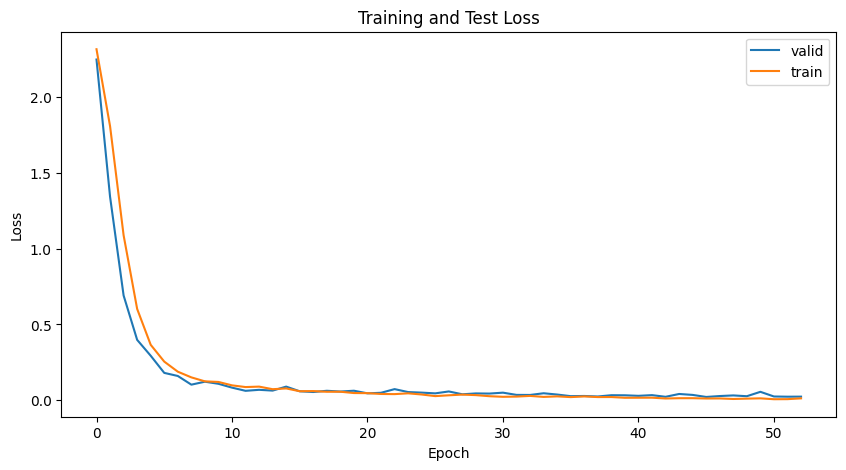

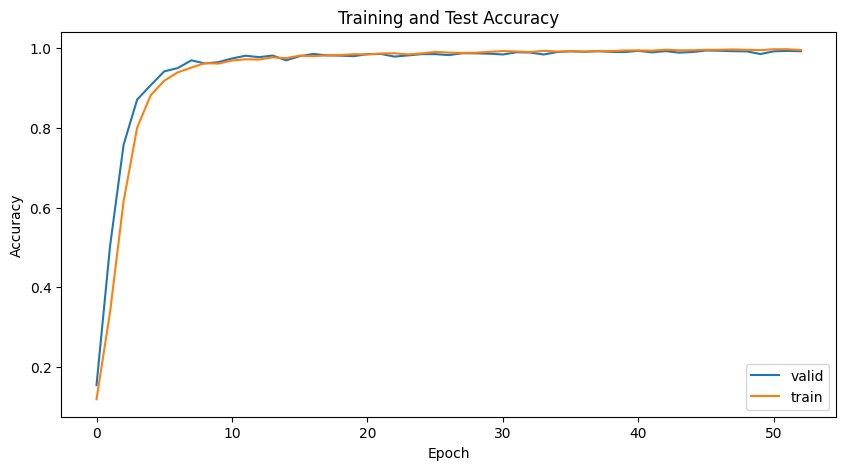

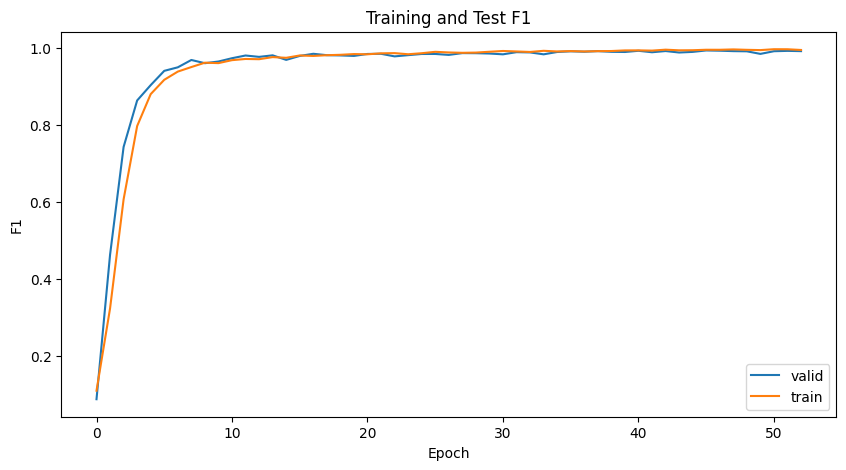

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [03:28<00:00,  5.97it/s]


In [18]:
df.to_csv(f'submission {model_name}.csv', index=False)